# Spectrophotometric Calibration

See "Improved Spectrophotometric Calibration of the SDSS-III BOSS Quasar Sample", [arxiv:1506.04790]( http://arxiv.org/abs/1506.04790).

## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import bossdata
print bossdata.__version__

0.2.8dev


/Users/david/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Sample Statistics

Open the DR12 metadata file:

In [3]:
spAll = bossdata.meta.Database(lite=False)

Lookup the target bit that identifies an offset standard-star target:

In [4]:
qso_std = bossdata.bits.ANCILLARY_TARGET2.QSO_STD

Find all offset standard-star targets from the ancillary program:

In [27]:
offset_standards = spAll.select_all(
    where='ANCILLARY_TARGET2 & {mask} != 0'.format(mask=qso_std),
    what='PLATE,MJD,FIBER,LAMBDA_EFF,OBJTYPE,CLASS,ZWARNING,ANCILLARY_TARGET2')

In [63]:
offset_standards.write('offset_standards.fits', overwrite=True)

We only use targets confirmed as stars and with no other ancillary target bits set:

In [34]:
confirmed_stars = (offset_standards['CLASS'] == 'STAR')
only_qso_std = (offset_standards['ANCILLARY_TARGET2']==qso_std)
num_confirmed = np.count_nonzero(confirmed_stars & only_qso_std)

There are only 4 confirmed stars with other ancillary target bits set (QSO_VAR_SDSS and QSO_XD_KDE_PAIR), but we don't understand how this happened so we omit them:

In [39]:
bossdata.bits.summarize_bitmask_values(bossdata.bits.ANCILLARY_TARGET2,
                                       offset_standards[confirmed_stars & ~only_qso_std]['ANCILLARY_TARGET2'])

{'QSO_STD': 4, 'QSO_VAR_SDSS': 1, 'QSO_XD_KDE_PAIR': 3}

Count how many different observations (PLATE-MJD) these confirmed stars occur on:

In [37]:
observations_by_plate = offset_standards[confirmed_stars].group_by(('PLATE', 'MJD'))
num_observations = len(observations_by_plate.groups)
print 'Found',num_confirmed,'offset targets confirmed as stars in',num_observations,'observations.'

Found 1770 offset targets confirmed as stars in 161 observations.


Count how many offset standards are on each spectrograph for each observation:

In [56]:
num_in_plate = np.diff(observations_by_plate.groups.indices)
num_in_spec1 = observations_by_plate['FIBER'].groups.aggregate(lambda fiber: np.count_nonzero(fiber < 501))
num_in_spec2 = observations_by_plate['FIBER'].groups.aggregate(lambda fiber: np.count_nonzero(fiber > 500))

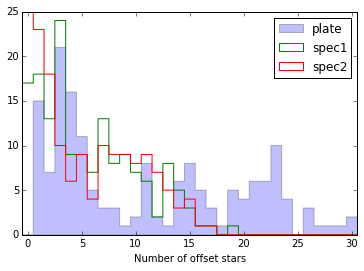

In [58]:
plt.hist(num_in_plate, bins=31, range=(-0.5, 30.5), histtype='stepfilled', alpha=0.25, label='plate')
plt.hist(num_in_spec1, bins=31, range=(-0.5, 30.5), histtype='step', label='spec1')
plt.hist(num_in_spec2, bins=31, range=(-0.5, 30.5), histtype='step', label='spec2')
plt.legend()
plt.xlim(-0.5, 30.5)
plt.xlabel('Number of offset stars')
plt.show()

Find plates with at least 10 offsets stars total:

In [59]:
plate_10_sample = (num_in_plate >= 10)
print np.count_nonzero(plate_10_sample),'plates have >= 10 offset stars.'

79 plates have >= 10 offset stars.


Find plates where both spectrographs have at least 10 offset stars each:

In [60]:
spec_10_sample = (num_in_spec1 >= 10) & (num_in_spec2 >= 10)
print np.count_nonzero(spec_10_sample),'plates have >= 10 + 10 offset stars.'

19 plates have >= 10 + 10 offset stars.


In [74]:
plate_mjd = observations_by_plate[['PLATE', 'MJD']].groups.aggregate(np.unique)
print plate_mjd[spec_10_sample]

PLATE  MJD 
----- -----
 6130 56214
 6131 56211
 6135 56192
 6136 56206
 6155 56245
 6157 56238
 6290 56238
 6293 56561
 6296 56219
 6297 56218
 6298 56208
 6307 56205
 6506 56564
 6509 56486
 6590 56273
 6681 56419
 6734 56386
 6816 56444
 6986 56717
